# Загрузка данных

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

In [104]:
# Загрузка данных
df = pd.read_excel('data/train.xlsx', index_col='dt')
df = df.asfreq('W-MON')  # Частота данных — еженедельно
df.head()

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300


In [105]:
df.shape

(400, 1)

In [106]:
df

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
...,...
2022-08-01,47500
2022-08-08,49000
2022-08-15,47500


In [ ]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
        
def check_stationary(column):
    p_value = adfuller(column)[1]
    print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')
    if p_value > 0.05:
        print(f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной. Ряд нестационарен')
    else:
        print(f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным')

check_stationarity(df['Цена на арматуру'])


ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Критические значения:
1%: -3.4470566389664703
5%: -2.8689037160476016
10%: -2.570692663557422


In [108]:
check_stationary(df['Цена на арматуру'])

Полученный уровень значимости (p-value): 0.32.
0.32 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной


In [109]:
# from scipy.stats import boxcox
# from scipy.special import inv_boxcox
# # Преобразование
# df['Цена на арматуру'], lambda_ = boxcox(df['Цена на арматуру'])
# # Обратное преобразование
# # time_series = inv_boxcos(time_series, lambda)

# check_stationarity(df['Цена на арматуру'])

In [110]:
check_stationary(df['Цена на арматуру'])

Полученный уровень значимости (p-value): 0.32.
0.32 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной


<Axes: xlabel='dt'>

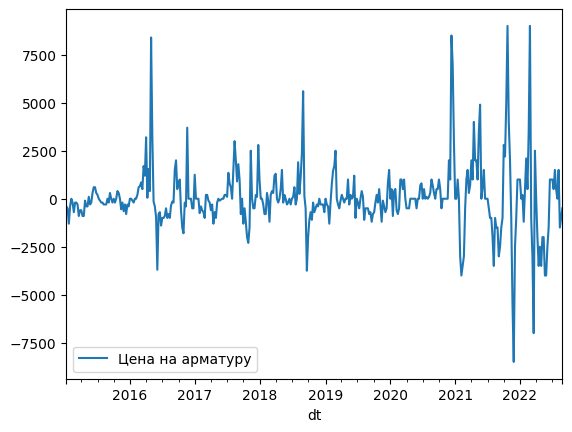

In [111]:
df_train_diff = df.diff().dropna()
df_train_diff.plot()

In [112]:
df_train_diff

,Цена на арматуру
dt,
2015-01-12,-400.0
2015-01-19,-500.0
2015-01-26,-1300.0
2015-02-02,-400.0
2015-02-09,0.0
...,...
2022-08-01,0.0
2022-08-08,1500.0
2022-08-15,-1500.0


In [113]:
check_stationarity(df_train_diff['Цена на арматуру'])

ADF Statistic: -7.7060615041152065
p-value: 1.3006938373810178e-11
Критические значения:
1%: -3.447405233596701
5%: -2.8690569369014605
10%: -2.5707743450830893


In [114]:
check_stationary(df_train_diff['Цена на арматуру'])

Полученный уровень значимости (p-value): 0.0.
0.0 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной. Ряд можно называть стационарным


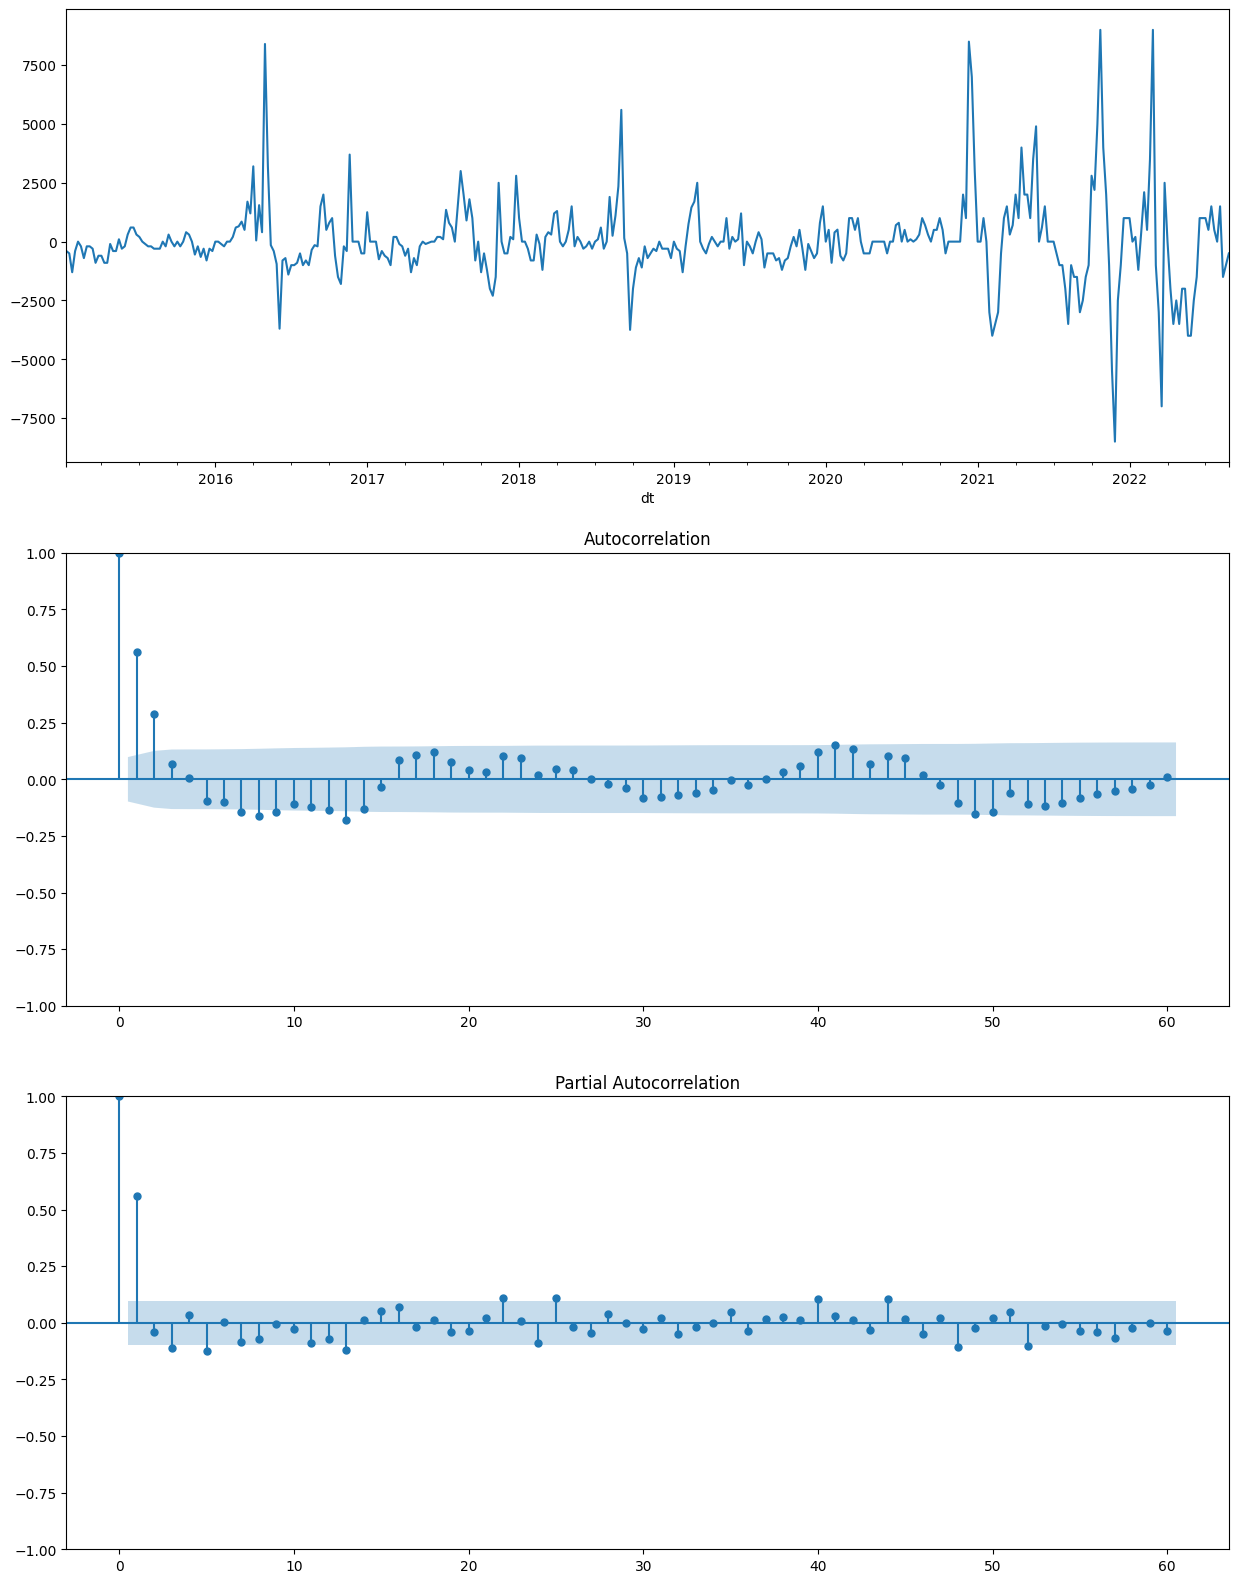

In [115]:
# вывод кореллограмм и ? (аргументировать зачем)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
df_train_diff['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df_train_diff['Цена на арматуру'], lags=60, ax=ax[2]);

In [116]:
# Разделение данных
test_size = int(len(df) * 0.2)
train, test = df_train_diff.iloc[:-test_size], df_train_diff.iloc[-test_size:]

# Модели

## SARIMAX

In [117]:
# # отключаем безвредные предупреждения
# warnings.filterwarnings("ignore") 
  
# # рассчёт лучших значений для ARIMA 
# stepwise_fit = auto_arima(df_train_diff['Цена на арматуру'], start_p = 1, start_q = 1, 
#                           max_p = 3, max_q = 3, m = 12, 
#                           start_P = 0, seasonal = True, 
#                           d = None, D = 1, trace = True, 
#                           error_action ='ignore',   # we don't want to know if an order does not work 
#                           suppress_warnings = True,  # we don't want convergence warnings 
#                           stepwise = True)           # set to stepwise 
  
# stepwise_fit.summary() 

In [118]:
model = SARIMAX(train, 
				order = (3, 0, 2), 
				seasonal_order =(0, 1, 1, 12)) 

result = model.fit() 
result.summary() 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Цена на арматуру   No. Observations:                  319
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2593.955
Date:                              Mon, 24 Mar 2025   AIC                           5201.911
Time:                                      23:44:59   BIC                           5227.999
Sample:                                  01-12-2015   HQIC                          5212.343
                                       - 02-15-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4776      0.099     24.904      0.000       2.283       2.673
ar.L2         -2.0088      0.142    -14.123      0.000      -2.288      -1.730
ar.L3          0.5305      0.047     11.198      0.000       0.438       0.623
ma.L1         -1.9516      0.119    -16.357      0.000      -2.185      -1.718
ma.L2          0.9516      0.119      7.998      0.000       0.718       1.185
ma.S.L12      -0.9433      0.056    -16.808      0.000      -1.053      -0.833
sigma2      1.187e+06   1.49e-07   7.97e+12      0.000    1.19e+06    1.19e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):              4886.84
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             2.88
Prob(H) (two-sided):                  0.47   Kurtosis:                        21.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+29. Standard errors may be unstable.
"""

In [119]:
forecast = result.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

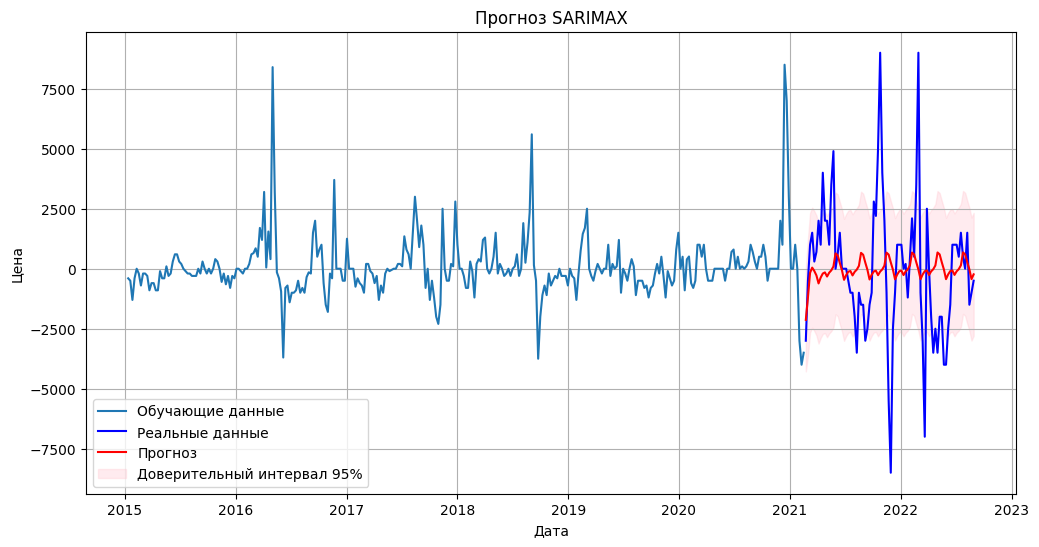

In [120]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Обучающие данные')
plt.plot(test.index, test, label='Реальные данные', color='blue')
plt.plot(test.index, pred, label='Прогноз', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Доверительный интервал 95%')
plt.title('Прогноз SARIMAX')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

In [121]:
# Метрики
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
mape = mean_absolute_percentage_error(test, pred)
r2 = r2_score(test, pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 2073.61
MSE: 8181712.77
MAPE: 143467914761300096.00%
R²: -0.0291
